In [1]:
#
# David Laziuk
# Random Forest from scratch
#

In [2]:
#My own random forest class, built off of my decision tree functions
class DavidsRandomForest:
    def __init__(self):
        self.nodes=[]
        
    #Function to get Gini Impurity of Split
    def get_impurity(self,X,y,col,val,terminate):
        #Store predicted class if clean split
        lPred,rPred=-1,-1
        #Store all sample indexes that satisfy & fail given condition
        idxL=X[X[col]<=val].index
        idxR=X[X[col]>val].index
        #Class composition of samples after split
        compL=y[idxL].value_counts()
        compR=y[idxR].value_counts()
        #LEFT SPLIT: Condition Satisfied
        #Case 1: All samples satisfy condition, max impurity returned
        # ~Impurity of an empty set is undefined, but 1 is chosen as this split is worthless
        #!!!!
        #In some bootstrapped sets, all possible splits will be worthless, so the branch will be terminated
        if(len(compL)==0):
            lPred=0 if(compR.index[0]==1) else 1
            rPred=compR.index[0]
            return 1,lPred,rPred
        #Case 2: Samples satisfying condition are all same class, lowest impurity (0)
        #Store Class to be returned as perfect split
        elif(len(compL)==1):
            leftS=compL.iloc[0]
            leftI=0
            lPred=compL.index[0]
        #Case 3: Samples satisying condition have mixed class, calculate impurity
        else:
            leftS=(compL[0]+compL[1])
            #Probability of each class
            p0L=compL[0]/leftS
            p1L=compL[1]/leftS
            #Impurity = 1-(P(c1)^2+P(c2)^2)
            leftI=1-((p0L**2)+(p1L**2))
            #If max_depth is reached, predict majority class and end branch
            #Predict malignant if even, FP is prefered in reality (Could be changed to random)
            if(terminate):
                lPred=0 if(compL[0]>compL[1]) else 1
        #RIGHT SPLIT: Condition not satisfied
        #Repeat cases 1-3 identically
        if(len(compR)==0):
            rPred=0 if(compL.index[0]==1) else 1
            lPred=compL.index[0]
            return 1,lPred,rPred
        elif(len(compR)==1):
            rightS=compR.iloc[0]
            rightI=0
            rPred=compR.index[0]
        else:
            rightS=(compR[0]+compR[1])
            p0R=compR[0]/rightS
            p1R=compR[1]/rightS
            rightI=1-((p0R**2)+(p1R**2))
            if(terminate):
                rPred=0 if(compR[0]>compR[1]) else 1
        #Size of parent node
        nodeS=leftS+rightS
        #Parent Node Impurity= Weighted Average of child impurities
        nodeI=((leftS/nodeS)*leftI)+((rightS/nodeS)*rightI)
        return nodeI,lPred,rPred
    
    #Function to find condition(feature<=value) with lowest Gini Impurity for data
    def get_split(self,X,y,terminate,cols):
        #Best Impurity,Column/Feature,Value  If perfect split: Best Left/Right class prediction
        bestI=1.1
        bestC=''
        bestV,bestL,bestR=-1,-1,-1
        #Check each Feature (Only selected from provided reduced set)
        for col in cols:
            #Find all values contained in feature
            comp=sorted(list(X[col].value_counts().index))
            #Test all values (except max val, nothing greater)
            for val in comp:
                if(val!=10):
                    #Get Impurity of Condition
                    I,lPred,rPred=self.get_impurity(X,y,col,val,terminate)
                    #Store if Lowest
                    if(I<bestI):
                        bestI,bestC,bestV,bestL,bestR=I,col,val,lPred,rPred
        return bestI,bestC,bestV,bestL,bestR
    
    #Node class: Contains col, cond, path & Leaf(Class if perfect split)
    class Node:
        def __init__(self,Col,Val,Path,Leaf):
            self.Col=Col
            self.Val=Val
            self.Path=Path
            self.Leaf=Leaf
    
    #Bootstrapping function       
    def bootstrap(self,X,y):
        Xr,yr=[],[]
        #Repeat till new data is same size
        while(len(Xr)<X.shape[0]):
            #Random sample WITH replacement
            pos=random.randint(0,X.shape[0]-1)
            Xr.append(X.iloc[pos])
            yr.append(y.iloc[pos])
        #New data -> dataframe
        Xr=pd.DataFrame(Xr).reset_index(drop=True)
        yr=pd.Series(yr).reset_index(drop=True)
        return Xr,yr
            
    #Recursive function to fit CART decision tree 
    def growTree(self,X,y,path,max_depth,cols):
        #Terminate if max_depth reached
        terminate=False
        if(len(path)>=max_depth-1): terminate=True 
        #RANDOM FOREST CHANGES \/
        #Bootstrapping if tree has just been started
        if(len(self.nodes)==0):
            X,y=self.bootstrap(X,y)
            #Selecting a subtset of features for this tree to be built on
            all_cols=X.columns
            cols=list(all_cols[random.sample(range(0,X.shape[1]-1),3)])
        ##########################
        #Get best split for data
        I,col,val,lPred,rPred=self.get_split(X,y,terminate,cols)
        #Add parent node to list, Leaf will be None as function will not be called for data of same class
        self.nodes.append(self.Node(col,val,path,None))
        #Child Node Operations
        #If left node is leaf: Add leaf node to list with path+'l'
        if(lPred!=-1):
            self.nodes.append(self.Node(None,None,path+'l',lPred))
        else:
            #Reset indexes of data
            X=X.reset_index(drop=True)
            y=y.reset_index(drop=True)
            #Find indexes of samples satisfying condition
            idxL=X[X[col]<=val].index
            #Pass data of samples satisfying condition to be split, with path+'l'
            Xl,yl=X.iloc[idxL],y.iloc[idxL]
            self.growTree(Xl,yl,path+'l',max_depth,cols)
        #Same operations for samples failing condition (right), with path+'r'
        if(rPred!=-1):
            self.nodes.append(self.Node(None,None,path+'r',rPred))
        else:
            X=X.reset_index(drop=True)
            y=y.reset_index(drop=True)
            idxR=X[X[col]>val].index
            Xr,yr=X.iloc[idxR],y.iloc[idxR]
            self.growTree(Xr,yr,path+'r',max_depth,cols)
    
    #Function to grow forest
    def growForest(self,size,X,y,draw):
        #Stores all sets of nodes(trees)
        trees=[]
        #Grow forest to size w/ default max_depth of 4
        for i in range(size):
            self.nodes=[]
            self.growTree(X,y,"",4,[])
            trees.append(self.nodes)
            if draw:
                clear_output(wait=True)
                print('Tree ('+str(len(trees))+'/'+str(size)+')')
                self.drawTree(self.nodes)
        return trees
    
    #Function to draw Tree
    def drawTree(self,ns):
        #Find depth, not necessarily=max_depth
        depth=-1
        for n in ns:
            if(len(n.Path)>depth):
                depth=len(n.Path)
        #Get full tree with all possible paths (for formatting)
        trash,full=self.fullTree([],'',depth)   
        #Iterate through all layers
        for l in range(depth+1):
            spacing=(7*(2**(depth-l)))#Exponentially increasing spacing based on height of layer
            #Find all nodes in layer based on path length
            paths=[]
            for n in ns:
                if(len(n.Path)==l):
                    paths.append(n.Path)
            #Print first node individually
            if(l==0):
                temp='('+ns[0].Col+'<='+str(ns[0].Val)+')'
                print(temp.center(spacing),end='')
            #Find all possible paths for layer
            pps=[]
            for f in full:
                if(len(f)==l):
                    pps.append(f)         
            #Main Print
            for p in pps:#Check all possible paths in layer
                if p in paths:#If path exists proceed
                    for i in range(len(ns)):#Search through all nodes
                        if(ns[i].Path==p):#If path matches proceed
                            if(ns[i].Leaf==None):#If not leaf print condition
                                temp='('+ns[i].Col+'<='+str(ns[i].Val)+')'
                                print(temp.center(spacing),end='')
                            else:#If leaf print prediction
                                temp='(  '+str(ns[i].Leaf)+'  )'
                                print(temp.center(spacing),end='')
                #Else print spacing
                else:
                    print('       '.center(spacing),end='')
            print()#End line
            
    #Recursive method of getting all possible paths in a tree of set depth
    def fullTree(self,paths,path,depth):
        if(len(path)<depth):
            p1,d=self.fullTree(paths,path+'l',depth)
            paths.append(p1)
            p2,d=self.fullTree(paths,path+'r',depth)
            paths.append(p2)
        return path,paths

    #Function to test forest
    def testForest(self,trees,X_test,y_test):
        acc,tp,tn,fp,fn=0,0,0,0,0
        #Iterate through test samples
        for i in range(X_test.shape[0]):
            #Extract truth
            truth=y_test.iloc[i]
            votes0,votes1,winner=0,0,0
            #Iterate through trees
            for nodes in trees:
                pred=-1
                path=''#Start with empty path (top node)
                #Loop until prediction(leaf) is found
                while(pred==-1):
                    #Linear Search for node satisfying path
                    #This is very unoptimized for readability
                    #Optimal solution would be for Node Class to reference parent/children directly
                    pos=-1
                    for p in range(len(nodes)):
                        if(nodes[p].Path==path):
                            pos=p
                            break
                    #If node satisfying path is leaf, store prediction
                    if(nodes[pos].Leaf!=None):
                        pred=nodes[pos].Leaf
                        #Add vote for prediction
                        if(pred==0): votes0+=1 
                        if(pred==1): votes1+=1 
                    #If node satisying path is condition, test
                    else:
                        #Path+'l' if satisfied, +'r' otherwise, go deeper
                        path+="l" if(X_test.loc[i,nodes[pos].Col]<=nodes[pos].Val) else "r"
            #Predict class with max votes
            winner=0 if(max(votes0,votes1)==votes0) else 1
            if(winner==truth): acc+=1
            if(truth==0 and winner==0): tn+=1
            if(truth==1 and winner==1): tp+=1
            if(truth==0 and winner==1): fp+=1
            if(truth==1 and winner==0): fn+=1            
        clear_output(wait=True)
        print('Accuracy: '+str(acc/y_test.shape[0]))
        return tp,tn,fp,fn

In [3]:
#Imports
import random
import numpy as np
import pandas as pd
#!!! only used for visualization if option to display trees while training enabled
from IPython.display import clear_output
#Loading Data
data=pd.read_csv('breast-cancer-wisconsin.csv',na_values= "?")
#Dropping rows with NAs
data=data.dropna()
#Fixing value type
data['F6']=data['F6'].astype(int)
#Mapping class(2/4) to (0/1)
data['Class']=data['Class'].replace(2,0)
data['Class']=data['Class'].replace(4,1)
data['Class']=data['Class'].astype(int)
#Dropping Sample ID Column
data=data.iloc[:,1:]
#Shuffling Entries
data=data.sample(frac=1).reset_index(drop=True)
#70/30 split into train/test data
train_size=int(np.floor(data.shape[0]*.7))
features=(data.shape[1]-1)
X_train=data.iloc[0:train_size,0:features].reset_index(drop=True)
X_test=data.iloc[train_size:,0:features].reset_index(drop=True)
y_train=data.iloc[0:train_size,features].reset_index(drop=True)
y_test=data.iloc[train_size:,features].reset_index(drop=True)
del features,train_size

In [4]:
f=DavidsRandomForest()
trees=f.growForest(100,X_train,y_train,True)#<-- Change to False to not draw trees
tp,tn,fp,fn=f.testForest(trees,X_test,y_test)

Accuracy: 0.9804878048780488


# Example of training with draw trees enabled:
![Forest](RandomForest.gif)

0    141
1     64
Name: Class, dtype: int64


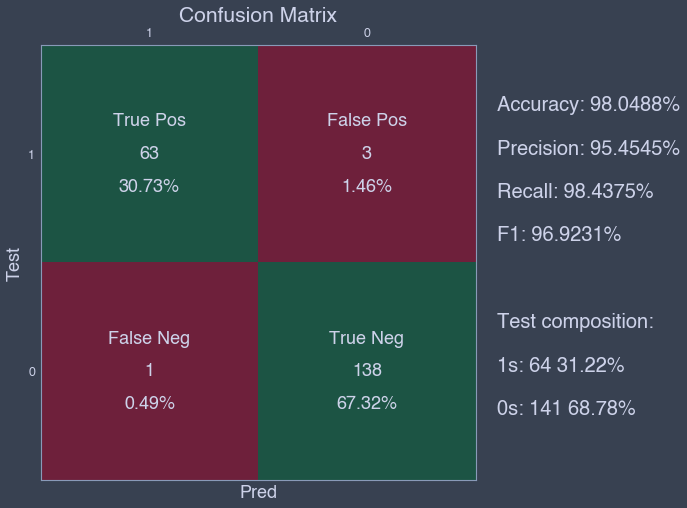

In [5]:
#Graphical Confusion Matrix & Metrics
#Just used for visualization, not relevant to solution \/
from jupyterthemes import jtplot
jtplot.style(grid=False)
import matplotlib.pyplot as plt
tot=tn+fp+fn+tp
#Structure of plot
cm=np.array(((1,0),(0,1)))
fig,ax=plt.subplots(figsize=(8,8))
plt.xlabel('Pred', fontsize=18)
plt.ylabel('Test', fontsize=18)
plt.title('Confusion Matrix', fontsize=21)
ax.set_xticks(np.arange(2))
ax.set_yticks(np.arange(2))
ax.set_xticklabels(['1','0'])
ax.set_yticklabels(['1','0'])
ax.matshow(cm,cmap='RdYlGn',alpha=0.5)
#Numeric vals
ax.text(0,0,s=tp,va='center',ha='center',fontsize=18)
ax.text(1,0,s=fp,va='center',ha='center',fontsize=18)
ax.text(0,1,s=fn,va='center',ha='center',fontsize=18)
ax.text(1,1,s=tn,va='center',ha='center',fontsize=18)
#Labels
ax.text(0,-.15,s="True Pos",va='center',ha='center',fontsize=18)
ax.text(1,-.15,s="False Pos",va='center',ha='center',fontsize=18)
ax.text(0,.85,s="False Neg",va='center',ha='center',fontsize=18)
ax.text(1,.85,s="True Neg",va='center',ha='center',fontsize=18)
#Percentages
ax.text(0,.15,s=str(round((tp/tot)*100,2))+'%' ,va='center',ha='center',fontsize=18)
ax.text(1,.15,s=str(round((fp/tot)*100,2))+'%' ,va='center',ha='center',fontsize=18)
ax.text(0,1.15,s=str(round((fn/tot)*100,2))+'%' ,va='center',ha='center',fontsize=18)
ax.text(1,1.15,s=str(round((tn/tot)*100,2))+'%' ,va='center',ha='center',fontsize=18)
#Result overview
acc=(tp+tn)/(tp+tn+fp+fn)
pre=(tp)/(tp+fp)
rec=(tp)/(tp+fn)
ax.text(1.6,-.2,"Accuracy: "+str(round((acc)*100 ,4))+'%',fontsize=20)
ax.text(1.6,0,"Precision: "+str(round((pre)*100 ,4))+'%',fontsize=20)
ax.text(1.6,.2,"Recall: "+str(round((rec)*100 ,4))+'%',fontsize=20)
ax.text(1.6,.4,"F1: "+str(round(( 2*((pre*rec)/(pre+rec)) )*100 ,4))+'%',fontsize=20)
c=y_test.value_counts()
print(c)
t1=c[1]
t0=c[0]
ax.text(1.6,.8,"Test composition:",fontsize=20)
ax.text(1.6,1,"1s: "+str(t1)+" "+str(round((t1/(t1+t0))*100 ,2))+'%',fontsize=20)
ax.text(1.6,1.2,"0s: "+str(t0)+" "+str(round((t0/(t1+t0))*100 ,2))+'%',fontsize=20)
del acc,ax,cm,fig,fn,fp,pre,rec,tn,tot,tp
plt.show()

# Comparing to Scikit-learn implementation:

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
data=pd.read_csv('breast-cancer-wisconsin.csv',na_values= "?")
data=data.iloc[:,1:]
data=data.dropna()
X_train,X_test,y_train,y_test=train_test_split(data.iloc[:,:-1],data.iloc[:, -1],test_size=0.3)
rf=RandomForestClassifier(n_estimators=100)
rf.fit(X_train,y_train)
y_pred=rf.predict(X_test)
acc=accuracy_score(y_test,y_pred)
print('Accuracy: '+str(acc))

Accuracy: 0.975609756097561
